In [18]:
import pymongo
import sympy
from sympy.parsing.sympy_parser import parse_expr
import os

In [3]:
# Maybe you have to change mongo url to something else if you're non the DAQ network? See cax.config.
client = pymongo.MongoClient('mongodb://eb:%s@xenon1t-daq.lngs.infn.it:27017/run' % os.environ['MONGO_PASSWORD'])

# Check format from purity collection

In [14]:
purity_coll = client['run']['purity']
purity_coll.count()

12

In [15]:
d = purity_coll.find_one()

In [17]:
for d in purity_coll.find(sort=(('calculation_time', -1), )):
    print(str(d['calculation_time']), parse_expr(d['function']))

2017-02-15 10:36:32.554000 571.536805205327/(1 + 2.85936983046934e+138*exp(-2.15875349579075e-7*t))
2017-02-09 11:34:52.728000 726.439274517567/(1 + 2.0260694424652e+84*exp(-1.3126159999747e-7*t))
2017-02-08 12:40:54.433000 726.439274517567/(1 + 2.0260694424652e+84*exp(-1.3126159999747e-7*t))
2017-01-12 16:57:05.376000 664.009433008032/(1 + 9.20429790014259e+57*exp(-9.05409401619292e-8*t))
2016-12-07 15:24:34.858000 3293.34246828997/(1 + 3.61800535059737e+15*exp(-2.29229212119497e-8*t))
2016-10-19 10:10:51.244000 451.092742358951/(1 + 2.19032421518171e+1011*exp(-1.57823407887515e-6*t))
2016-09-19 05:55:53.102000 317.29661042819/(1 + 1.05633549046867e+880*exp(-1.37598762559539e-6*t))
2016-09-19 05:55:53.102000 317.29661042819/(1 + 1.05633549046867e+880*exp(-1.37598762559539e-6*t))
2016-07-26 10:23:33.859000 323.085761530256/(1 + 2.60535248526874e+1028*exp(-1.61211864700664e-6*t))
2016-07-26 10:23:33.859000 323.085761530256/(1 + 2.60535248526874e+1028*exp(-1.61211864700664e-6*t))
2016-07

# Try to add drift velocity correction function

In [21]:
import numpy as np

In [132]:
data = np.array([
    4,  0.9948,       # Julien
    5,  1.1224,       # Julien
    6,  1.2137,       # Julien
    7,  1.2833,       # Julien
    8,  1.3323,       # Julien
    9,  1.371,        # Jelle
    12, 1.4401,       # Jelle & Julien (same value, well Julien had 1.4402 and I had 1.440...)
    13, 1.456,
    15, 1.482
])

cathode_kv, vdrift_kmpers = data.reshape(-1, 2).T

In [133]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

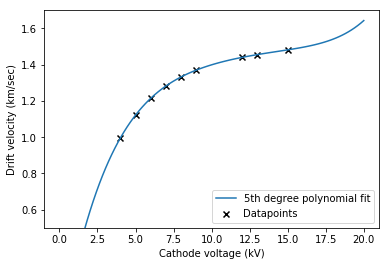

In [149]:
vs = np.linspace(0, 20, 100)

deg = len(cathode_kv) - 4
coeffs = np.polyfit(cathode_kv, vdrift_kmpers, deg=deg)
plt.plot(vs, np.polyval(coeffs, vs), label='%dth degree polynomial fit' % deg)
plt.scatter(cathode_kv, vdrift_kmpers, marker='x', c='k', label='Datapoints')

plt.ylim(0.5, 1.7)
plt.legend(loc='lower right')
plt.xlabel("Cathode voltage (kV)")
plt.ylabel("Drift velocity (km/sec)")

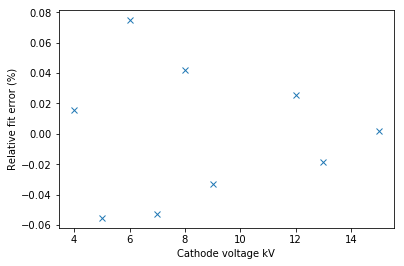

In [150]:
plt.plot(cathode_kv, 100 * (np.polyval(coeffs, cathode_kv) - vdrift_kmpers)/vdrift_kmpers, 
         linestyle='', marker='x')
plt.ylabel('Relative fit error (%)')
plt.xlabel("Cathode voltage kV")

Systematic error on drift velocity estimates is around 0.2%, see : https://xecluster.lngs.infn.it/dokuwiki/doku.php?id=xenon:xenon1t:aalbers:drift_and_diffusion#results

so if the fitter error is much less than this, we're ok.

## Make sympy function

In [153]:
v = sympy.Symbol('v')
sp_poly = sympy.Poly.from_list(coeffs.tolist(), gens=v)

In [155]:
# Sanity check:
sp_poly.subs(dict(v=7.5))

1.30959670337438

In [166]:
# Try converting to and from serialization format, repeat sanity check
serialized_fit = sympy.srepr(sp_poly)
parse_expr(serialized_fit).subs(dict(v=7.5))

1.30959670337438

## Insert in runs db

In [167]:
drift_coll = client['run']['drift_velocity']

In [173]:
from datetime import datetime

In [172]:
# Uncomment this, adjust versions and comments to do actual insertion
# drift_coll.insert_one(dict(
#     version='1.0.0',
#     calculation_time=datetime.now(),
#     function=serialized_fit,
#     comment="5th degree polynomial fit to Julien&Jelle's Drift velocity results. Jelle, 1 April 2017."
# ))